<a href="https://colab.research.google.com/github/WilliamPoe/CSCI-290/blob/main/notebooks/k_means_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [52]:
class KMeans_clustering:

    def __init__(self, k=3, max_iterations=100):
        self.k = k
        self.max_iterations = max_iterations

    def euclidean_distance(self, point1, point2): # Calculate the euclidean distance
        return np.sqrt(np.sum((np.array(point1) - np.array(point2))**2))

    def ran_centroids(self, data): # Picks random centroids from dataset
        ran_centroids = data.sample(self.k).index
        return data.loc[ran_centroids]

    def calc_centroids(self, clusters, data): # Calculate the new centroids from the clusters
        centroids = pd.DataFrame(columns=data.columns, index=range(self.k))
        for i, cluster in enumerate(clusters):
            centroids.iloc[i] = np.mean(data.iloc[[idx for idx in cluster]], axis=0)
        return centroids

    def distances(self, point, centroids): # Calculate the distance between the data and the centroids using euclidean distances function
        distances = [self.euclidean_distance(point, centroid) for _, centroid in centroids.iterrows()]
        return np.argmin(distances)

    def clustering(self, data, centroids): # Clusters the data together based off of the calculated distances
        clusters = [[] for _ in range(self.k)]
        labels = np.empty(self.n_samples)
        for idx in range(data.shape[0]):
            point = data.iloc[idx]
            cluster_index = self.distances(point, centroids)
            clusters[cluster_index].append(idx)
            labels[idx] = cluster_index
        return clusters, labels

    def fit(self, data): # Fits the data
      self.n_samples, self.n_features = data.shape[0], data.shape[1]
      print('The number of samples is:',self.n_samples)
      print('The number of features is:',self.n_features)
      self.centroids = self.ran_centroids(data)

      for iteration in range(self.max_iterations):
        self.clusters, self.labels = self.clustering(data, self.centroids)
        cur_centroids = self.calc_centroids(self.clusters, data)

        if (iteration / 10) % 1 == 0 or iteration == 1:

          plt.figure(figsize=(5, 3))

          # Plots the data points with cluster colors
          sns.scatterplot( x = data.iloc[:, 0], y = data.iloc[:, 1], hue = self.labels, palette='viridis', s=50)

          # Plots the centroids with a different color
          print('test1:',cur_centroids.iloc[:, 0])
          print('test2:',cur_centroids.iloc[:, 1])
          sns.scatterplot( x = cur_centroids.iloc[:, 0], y = cur_centroids.iloc[:, 1], c = "black", marker="x", s = 100);

          plt.title(f'Cluster Visualization - Iteration {iteration}')
          plt.xlabel('Feature 1')
          plt.ylabel('Feature 2')

          plt.show()

        if self.centroids.equals(cur_centroids.set_index(self.centroids.index)):
          break
        self.centroids = cur_centroids

bill_length_mm       float64
bill_depth_mm        float64
flipper_length_mm    float64
body_mass_g          float64
dtype: object
The number of samples is: 342
The number of features is: 4
test1: 0    48.611111
1    44.636082
2    41.183537
Name: bill_length_mm, dtype: object
test2: 0    15.401235
1    17.143299
2    18.020122
Name: bill_depth_mm, dtype: object


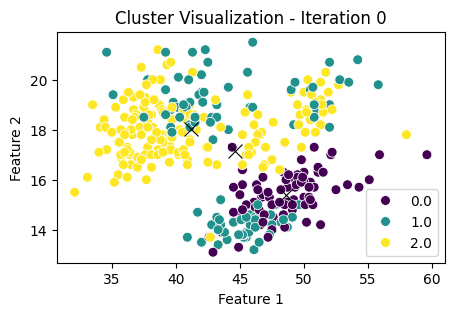

test1: 0    48.813514
1    44.759615
2    41.183537
Name: bill_length_mm, dtype: object
test2: 0    15.472973
1       16.975
2    18.020122
Name: bill_depth_mm, dtype: object


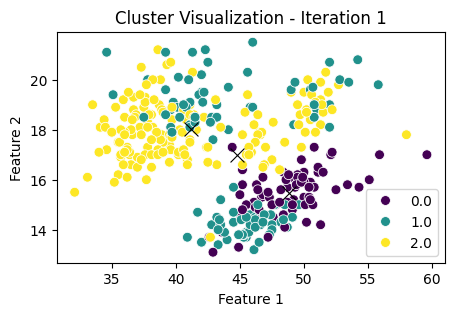

[2. 2. 2. 2. 2. 2. 1. 2. 1. 2. 2. 2. 2. 1. 2. 2. 1. 2. 1. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 1. 2. 2. 2. 1. 2. 1. 2. 2. 2.
 1. 2. 1. 2. 1. 2. 2. 2. 2. 2. 2. 2. 1. 2. 1. 2. 2. 2. 1. 2. 1. 2. 2. 2.
 1. 2. 1. 2. 2. 2. 1. 2. 1. 2. 1. 2. 2. 2. 2. 2. 2. 2. 1. 2. 1. 2. 1. 2.
 1. 2. 1. 2. 1. 2. 1. 2. 2. 2. 2. 2. 1. 2. 1. 2. 1. 2. 1. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 1. 2. 1. 2. 1. 2. 2. 2. 1. 2. 2. 2. 2. 2. 1. 2. 2. 2. 2. 2.
 2. 1. 2. 2. 2. 2. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 2.
 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.
 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.
 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 2. 2. 2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 2. 1.
 2. 1. 2. 2. 2. 1. 2. 2. 2. 2. 2. 1. 2. 2. 2. 1. 2. 1. 2. 1. 2. 2. 2. 1.
 2. 1. 2. 2. 2. 2. 2. 1. 2. 1. 2. 2. 2. 2. 2. 1. 2.

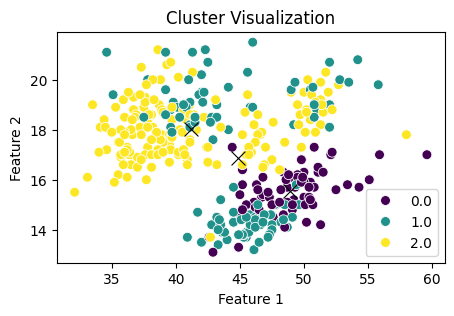

In [53]:
df = pd.read_csv('https://github.com/WilliamPoe/CSCI-290/raw/refs/heads/main/Data/penguins.csv')

def plot_clusters(data, labels, centroids):
    plt.figure(figsize=(5, 3))

    # Plots the data points with cluster colors
    sns.scatterplot( x = data.iloc[:, 0], y = data.iloc[:, 1], hue = labels, palette='viridis', s=50)

    # Plots the centroids with a different color
    sns.scatterplot( x = centroids.iloc[:, 0], y = centroids.iloc[:, 1], c = "black", marker="x", s = 100);

    plt.title('Cluster Visualization')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')

    plt.show()

numeric_df = df.select_dtypes(include=[np.number])

numeric_df = numeric_df.drop(columns='year')
numeric_df = numeric_df.dropna()
print(numeric_df.dtypes)


model = KMeans_clustering(k=3)
model.fit(numeric_df)
labels = model.labels
centroids = model.centroids


plot_clusters(numeric_df, labels, centroids)


In [40]:
def euclidean_distance(point1, point2): # Calculate the euclidean distance
        return np.sqrt(np.sum((np.array(point1) - np.array(point2))**2))

In [48]:
euclidean_distance(numeric_df.iloc[1], numeric_df.iloc[255])

925.5262286937092

In [49]:
numeric_df

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,39.1,18.7,181.0,3750.0
1,39.5,17.4,186.0,3800.0
2,40.3,18.0,195.0,3250.0
4,36.7,19.3,193.0,3450.0
5,39.3,20.6,190.0,3650.0
...,...,...,...,...
339,55.8,19.8,207.0,4000.0
340,43.5,18.1,202.0,3400.0
341,49.6,18.2,193.0,3775.0
342,50.8,19.0,210.0,4100.0
